# [Assignment 12](https://ovgu-ailab.github.io/idl2023/assignment12.html)
Adrian Bremer

## Setup

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tfk.layers

## Load the mixed up CIFAR-data

In [2]:
data1 = np.load("cifar_attempts/data1.npz")
list(data1.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [3]:
data2 = np.load("cifar_attempts/data2.npz")
list(data2.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [4]:
data3 = np.load("cifar_attempts/data3.npz")
list(data3.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [5]:
data4 = np.load("cifar_attempts/data4.npz")
list(data4.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

## Inspect the data distributions

In [13]:
def inspect_data(data):
    _,ax = plt.subplots(2,3)
    ax[0,0].hist(data['train_lbls'], bins=10)
    ax[0,1].hist(data['val_lbls'], bins=10)
    ax[0,2].hist(data['test_lbls'], bins=10)
    ax[1,0].hist(data['train_imgs'].flatten(), bins=100)
    ax[1,1].hist(data['val_imgs'].flatten(), bins=100)
    ax[1,2].hist(data['test_imgs'].flatten(), bins=100)
    plt.show()

### data1
> Labels 3 and 7 are missing in training and validation set.  
> I assume that images from these classes are wrongly labeled

> Test set performance will probably be really bad because of this

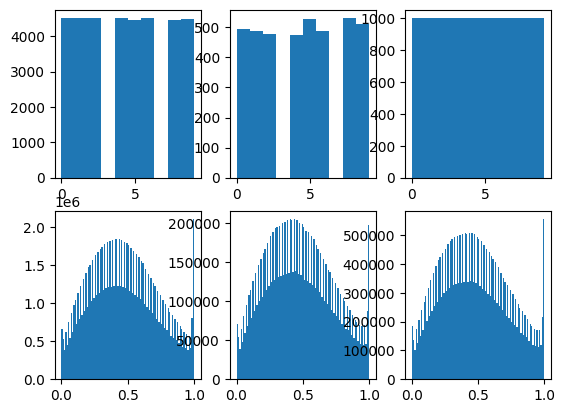

In [14]:
inspect_data(data1)

### data2
> Train and test set are of equal distribution.  
> And the test set could actually be a subset of the training set (the distributions look identical)...

> I assume that the validation loss will be higher than the test loss.  

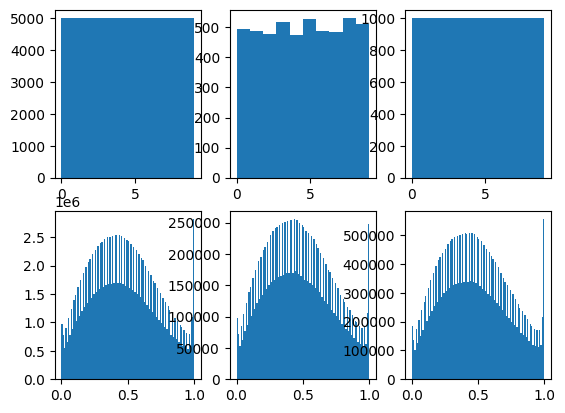

In [18]:
inspect_data(data2)

### data3
> Isn't looking too bad, but the distributions of training and test set are again fairly close to each other...

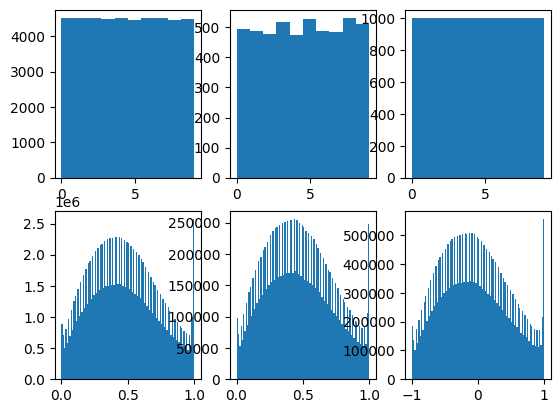

In [19]:
inspect_data(data3)

### data4
> Training, validation and test set are of exactly the same distribution.
> Training and validation set have really similar pictures while the test set has the "normal" expected distribution.

> I assume that test performance will be bad and that there might be wrongly labeled images in training and validation set or that there aren't all images contained, since the pixel value distribution is so different.

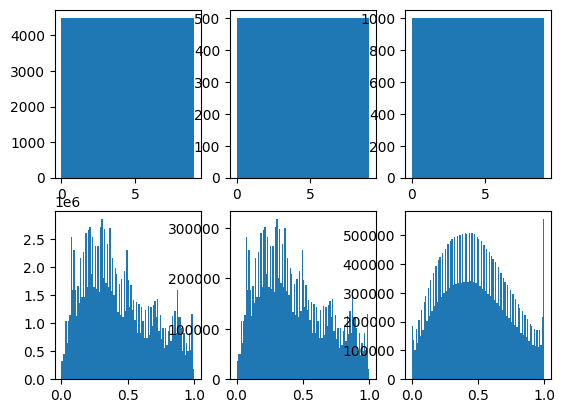

In [20]:
inspect_data(data4)

## Creating datasets from the different CIFAR data

In [26]:
def create_datasets(data):
    data_train = tf.data.Dataset.from_tensor_slices((data['train_imgs'], data['train_lbls'])).shuffle(50000).batch(128).repeat()
    data_val = tf.data.Dataset.from_tensor_slices((data['val_imgs'], data['val_lbls'])).shuffle(5000).batch(128)
    data_test = tf.data.Dataset.from_tensor_slices((data['test_imgs'], data['test_lbls'])).shuffle(10000).batch(128)
    return (data_train, data_val, data_test)

data1_train, data1_val, data1_test = create_datasets(data1)
data2_train, data2_val, data2_test = create_datasets(data2)
data3_train, data3_val, data3_test = create_datasets(data3)
data4_train, data4_val, data4_test = create_datasets(data4)

2024-01-18 15:01:55.674169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2024-01-18 15:01:57.038791: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


## Building a model (Inception)

In [22]:
def inception_block(inputs, n_filters):
    conv1_1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)

    conv1_3 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_3 = tf.keras.layers.Conv2D(n_filters, 3, padding="same")(conv1_3)

    conv1_5 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_5 = tf.keras.layers.Conv2D(n_filters, 5, padding="same")(conv1_5)

    pool1 = tf.keras.layers.MaxPool2D(3, 1, padding="same")(inputs)
    pool1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(pool1)

    concat1 = tf.concat([conv1_1, conv1_3, conv1_5, pool1], axis=-1)
    concat1 = tf.keras.layers.BatchNormalization()(concat1)
    concat1 = tf.nn.relu(concat1)
    concat1 = tf.keras.layers.SpatialDropout2D(0.05)(concat1)

    return concat1

def inception_model(input_shape=(32, 32, 3), blocks_per_resolution=2, filters=[32,64,128]):
    inputs = tf.keras.layers.Input(input_shape)

    x = inputs
    # model with data augmentation
    # these layers do random changes during training,
    # and mostly do nothing during testing (except RandomCrop, which will do a center-crop)
    x = tf.keras.layers.RandomRotation(0.075)(x)
    x = tf.keras.layers.RandomCrop(28, 28)(x)
    x = tf.keras.layers.RandomFlip("horizontal")(x)
    x = tf.keras.layers.RandomContrast(0.1)(x)
    x = tf.keras.layers.RandomBrightness(0.1, [0., 1.])(x)

    for n_filters in filters:
        for block in range(blocks_per_resolution):
            x = inception_block(x, n_filters)
        # downsample
        x = tf.keras.layers.MaxPool2D(padding="same")(x)

    pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
    logits = tf.keras.layers.Dense(10)(pooled)

    model = tf.keras.Model(inputs, logits, name="inception")
    
    return model

In [28]:
model = inception_model(blocks_per_resolution=1)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 random_rotation_2 (RandomR  (None, 32, 32, 3)            0         ['input_3[0][0]']             
 otation)                                                                                         
                                                                                                  
 random_crop_2 (RandomCrop)  (None, 28, 28, 3)            0         ['random_rotation_2[0][0]']   
                                                                                                  
 random_flip_2 (RandomFlip)  (None, 28, 28, 3)            0         ['random_crop_2[0][0]'

                                                                                                  
 conv2d_87 (Conv2D)          (None, 7, 7, 128)            32896     ['max_pooling2d_21[0][0]']    
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 256)            0         ['max_pooling2d_21[0][0]']    
 ng2D)                                                                                            
                                                                                                  
 conv2d_84 (Conv2D)          (None, 7, 7, 128)            32896     ['max_pooling2d_21[0][0]']    
                                                                                                  
 conv2d_86 (Conv2D)          (None, 7, 7, 128)            147584    ['conv2d_85[0][0]']           
                                                                                                  
 conv2d_88

## Training the model

### data1

In [30]:
history1 = model.fit(
    data1_train,
    epochs=10,
    steps_per_epoch=256,
    validation_data=data1_val,
    callbacks=[
        tfk.callbacks.EarlyStopping()
    ]
)

Epoch 1/10
256/256 [==============================] - 209s 815ms/step - loss: 1.2435 - accuracy: 0.5310 - val_loss: 1.9035 - val_accuracy: 0.3581
Epoch 2/10
256/256 [==============================] - 207s 810ms/step - loss: 1.0774 - accuracy: 0.6049 - val_loss: 1.1344 - val_accuracy: 0.5793
Epoch 3/10
256/256 [==============================] - 209s 815ms/step - loss: 0.9651 - accuracy: 0.6493 - val_loss: 0.9221 - val_accuracy: 0.6589
Epoch 4/10
256/256 [==============================] - 207s 808ms/step - loss: 0.8890 - accuracy: 0.6806 - val_loss: 0.7622 - val_accuracy: 0.7360
Epoch 5/10
256/256 [==============================] - 206s 805ms/step - loss: 0.8464 - accuracy: 0.6955 - val_loss: 0.8620 - val_accuracy: 0.6832


In [48]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.show()

In [45]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.show()